## Ames Housing Data Project 2    

### Problem Statement

Generally, home sellers desire to optimize the sale price for their homes. One way to increase your home price is to make home improvements and renovations to your house so that it can be more appealing to buyers. 

With the Ames housing data, I wil make a regression model to isolate the relationship between house features and  quality to sales price so that home sellers can use this information to inform their renovation decisions. 

With this model, home sellers can estimate the expected increse in sale price for specific house improvement projects. 

### The Data

In this analysis we use the data from the the Ames Assessor's Office which was used in computing assessed values for individual residential properties sold in Ames, IA from 2006 - 2010. 

For the purposes of our modeling process, the data set is split into the Train and the Test files, which contain the same number of variables, expect the test dataset does not contain the target variable (saleprice).


#### Data Dictionary 

The data dictionary is available [Here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import metrics

from sklearn.linear_model import LinearRegression,\
                                 Lasso, Ridge

from sklearn.linear_model import LassoCV, RidgeCV

from scipy import stats

import statsmodels.api as sm

#### Loading the datasets

In [2]:
train = pd.read_csv('../datasets/train.csv', keep_default_na=False)

In [3]:
train.shape

(2051, 81)

In [4]:
test = pd.read_csv('../datasets/test.csv', keep_default_na=False)

In [5]:
test.shape

(878, 80)

In [6]:
# .info to see data types and nulls
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Id               2051 non-null   int64 
 1   PID              2051 non-null   int64 
 2   MS SubClass      2051 non-null   int64 
 3   MS Zoning        2051 non-null   object
 4   Lot Frontage     2051 non-null   object
 5   Lot Area         2051 non-null   int64 
 6   Street           2051 non-null   object
 7   Alley            2051 non-null   object
 8   Lot Shape        2051 non-null   object
 9   Land Contour     2051 non-null   object
 10  Utilities        2051 non-null   object
 11  Lot Config       2051 non-null   object
 12  Land Slope       2051 non-null   object
 13  Neighborhood     2051 non-null   object
 14  Condition 1      2051 non-null   object
 15  Condition 2      2051 non-null   object
 16  Bldg Type        2051 non-null   object
 17  House Style      2051 non-null   

#### Clean column names

In [7]:
train.columns = train.columns.str.lower().str.replace(' ','_' )
test.columns = test.columns.str.lower().str.replace(' ','_' )

#### Make columns the right dtype

##### Train fix dtypes

In [8]:
train['ms_subclass'] = train['ms_subclass'].map(str)

In [9]:
make_int = ['lot_frontage','bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf',
            'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath',
            'garage_yr_blt', 'garage_cars', 'garage_area', 'mas_vnr_area']

In [10]:
for col in make_int:
    train[col] = train[col].replace('', 0)

In [11]:
for col in make_int: 
    print(col, sum(train[col]==''))

lot_frontage 0
bsmtfin_sf_1 0
bsmtfin_sf_2 0
bsmt_unf_sf 0
total_bsmt_sf 0
bsmt_full_bath 0
bsmt_half_bath 0
garage_yr_blt 0
garage_cars 0
garage_area 0
mas_vnr_area 0


In [12]:
for col in make_int:
    train[col] = train[col].map(int)

In [13]:
train[make_int].dtypes

lot_frontage      int64
bsmtfin_sf_1      int64
bsmtfin_sf_2      int64
bsmt_unf_sf       int64
total_bsmt_sf     int64
bsmt_full_bath    int64
bsmt_half_bath    int64
garage_yr_blt     int64
garage_cars       int64
garage_area       int64
mas_vnr_area      int64
dtype: object

##### Test dtype fix:

In [14]:
test['ms_subclass'] = test['ms_subclass'].map(str)

In [15]:
for col in make_int:
    test[col] = test[col].replace('', 0)

In [16]:
for col in make_int:
    test[col] = test[col].map(int)

In [17]:
test[make_int].dtypes

lot_frontage      int64
bsmtfin_sf_1      int64
bsmtfin_sf_2      int64
bsmt_unf_sf       int64
total_bsmt_sf     int64
bsmt_full_bath    int64
bsmt_half_bath    int64
garage_yr_blt     int64
garage_cars       int64
garage_area       int64
mas_vnr_area      int64
dtype: object

### Make Ordinal Columns

While I do not anticipate using all the columns I am about to tranform into ordinal in my project statement model, I cannot anticipate which of these columns may become useful in the predictive model for kraggle. So I will go ahead and make sure the dataframe has the right ordinal columns. 

For Categorical data, I will use OneHotEncoder

##### Make list of columns to change into ordinal and accompanying dictionaries

In [18]:
# Ex, Gd, TA, Fa, Po
make_ordinal_5 = ['exter_qual', 'exter_cond', 'heating_qc', 
                  'kitchen_qual']

In [19]:
ordinal_5 = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1
}

In [20]:
# Ex, Gd, TA, Fa, Po, NA
make_ordinal_0_5 = ['bsmt_qual', 'bsmt_cond', 'fireplace_qu',
                    'garage_qual', 'garage_cond', 'pool_qc']

In [21]:
ordinal_0_5 = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

In [22]:
# Gd, Av, Mn, No, Na
make_ordinal_0_4 = ['bsmt_exposure']

In [23]:
ordinal_0_4 = {
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 1,
    'NA': 0
}

In [24]:
# GdPrv, MnPrv, GdWo, MnWw, NA
make_ordinal_fence = ['fence']

In [25]:
ordinal_fence = {
    'GdPrv': 4,
    'MnPrv': 3,
    'GdWo': 2,
    'MnWw': 1,
    'NA': 0
}

In [26]:
# GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA 
make_ordinal_0_6 = ['bsmtfin_type_1', 'bsmtfin_type_2']

In [27]:
ordinal_0_6 = {
    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,
    'NA': 0
}

In [28]:
# Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal
make_ordinal_8 = ['functional']

In [29]:
ordinal_0_8 = {
    'Typ': 8,
    'Min2': 7,
    'Min1': 6,
    'Mod': 5,
    'Maj1': 4,
    'Maj2': 3,
    'Sev': 2,
    'Sal': 1
}

In [30]:
#Fin, RFn, Unf, Na
make_ordinal_0_3 = ['garage_finish']

In [31]:
ordinal_0_3 = {
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    'NA': 0   
}

In [32]:
make_ordinal_elec = ['electrical']

In [33]:
ordinal_elec = {
    'SBrkr': 5,
    'FuseA': 4,
    'FuseF': 3,
    'FuseP': 2,
    'Mix': 1,
}

#### Make a function make train and test ordinal

In [34]:
def make_ordinal_train(col_list, ord_dict):
    for col in col_list:
        train[col] = train[col].replace('', train[col].value_counts().idxmax())
    
    for col in col_list:
        train[col] = train[col].map(ord_dict)

In [35]:
def make_ordinal_test(col_list, ord_dict):
    for col in col_list:
        test[col] = test[col].replace('', train[col].value_counts().idxmax())
        # note that we are imputing with the train's mode
    
    for col in col_list:
        test[col] = test[col].map(ord_dict)

In [36]:
dictionaries = [ordinal_5, ordinal_0_5, 
                ordinal_0_4, ordinal_fence,
                ordinal_0_6, ordinal_0_8, 
                ordinal_0_3, ordinal_elec
               ]

In [37]:
make_ord_list = [make_ordinal_5, make_ordinal_0_5,
                 make_ordinal_0_4, make_ordinal_fence,
                 make_ordinal_0_6, make_ordinal_8,
                 make_ordinal_0_3, make_ordinal_elec
                ]

#### Make ordinals for Train

In [38]:
for i in range(8):
    make_ordinal_train(make_ord_list[i], dictionaries[i])

In [39]:
for item in make_ord_list:
    for col in item:
        print(col, train[col].unique())

exter_qual [4 3 5 2]
exter_cond [3 4 2 5 1]
heating_qc [5 3 4 2 1]
kitchen_qual [4 3 2 5]
bsmt_qual [3 4 2 0 5 1]
bsmt_cond [3 4 0 2 1 5]
fireplace_qu [0 3 4 1 5 2]
garage_qual [3 2 0 4 5 1]
garage_cond [3 2 0 1 4 5]
pool_qc [0 2 4 5 3]
bsmt_exposure [1 4 3 0 2]
fence [0 3 4 2 1]
bsmtfin_type_1 [6 1 5 3 0 4 2]
bsmtfin_type_2 [1 3 0 4 6 2 5]
functional [8 5 7 4 6 2 1 3]
garage_finish [2 1 3 0]
electrical [5 3 4 2 1]


**All the values look appropriate, no nan**

#### Make ordinals for Test

In [40]:
for i in range(8):
    make_ordinal_test(make_ord_list[i], dictionaries[i])

In [41]:
for item in make_ord_list:
    for col in item:
        print(col, test[col].unique())

exter_qual [3 4 2 5]
exter_cond [2 3 4 5 1]
heating_qc [4 3 5 2]
kitchen_qual [2 3 4 5 1]
bsmt_qual [2 4 3 5 0 1]
bsmt_cond [3 4 0 2]
fireplace_qu [0 4 2 3 1 5]
garage_qual [1 3 2 0 4]
garage_cond [1 3 0 2 4 5]
pool_qc [0 5 3]
bsmt_exposure [1 3 0 2 4]
fence [0 3 4 2 1]
bsmtfin_type_1 [1 6 4 3 5 0 2]
bsmtfin_type_2 [1 2 0 5 6 3 4]
functional [8 7 6 5 4 3]
garage_finish [ 1.  3.  2.  0. nan]
electrical [ 2.  5.  4.  3. nan]


In [42]:
test['garage_finish'].isna().sum()

1

In [43]:
test[test['garage_finish'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
764,1357,903426160,60,RM,57,8094,Pave,Grvl,Reg,Lvl,...,0,0,0,0,3,Shed,1000,9,2008,WD


We will assume the nan here is because the feature is not available for this property, therefore it is a 0

In [44]:
test.at[764, 'garage_finish'] = 0

In [45]:
test['garage_finish'].isna().sum()

0

In [46]:
test[test['electrical'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
634,1578,916386080,80,RL,73,9735,Pave,NA,Reg,Lvl,...,0,0,0,0,0,NA,0,5,2008,WD


In [47]:
test.at[634, 'electrical'] = 0

In [48]:
test['electrical'].isna().sum()

0

#### EDA

EDA on numerical columns

In [49]:
ordinal_cols = [col for item in make_ord_list for col in item ]

In [50]:
print(ordinal_cols)

['exter_qual', 'exter_cond', 'heating_qc', 'kitchen_qual', 'bsmt_qual', 'bsmt_cond', 'fireplace_qu', 'garage_qual', 'garage_cond', 'pool_qc', 'bsmt_exposure', 'fence', 'bsmtfin_type_1', 'bsmtfin_type_2', 'functional', 'garage_finish', 'electrical']


In [51]:
train_nums = train._get_numeric_data()

In [52]:
num_cols = [col for col in train_nums.columns if col not in ordinal_cols and col != 'id' and col != 'pid']

In [53]:
print(num_cols)

['lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold', 'saleprice']


From the above numeric columns, I have to make some choices as to the values that I believe are going to have to strongest effect on salesprice. 

In [54]:
len(num_cols)

36

Numerical features to explore:

In [55]:
num_explore1 = ['overall_qual', 'overall_cond', 'lot_area', 'year_built',
               'year_remod/add', 'gr_liv_area','full_bath', 'half_bath',
                'saleprice']
               

In [56]:
num_explore2 = ['bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
               'garage_cars','garage_area', 'wood_deck_sf', 'open_porch_sf','pool_area', 
               'saleprice']

In [57]:
num_explore3 = [col for col in num_cols if col not in num_explore1+num_explore2] + ['saleprice']

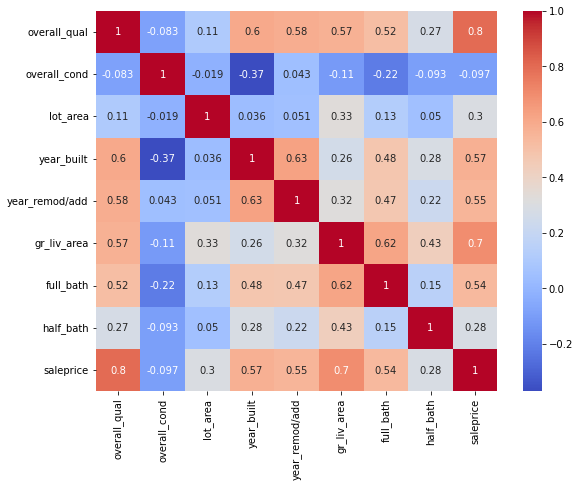

In [58]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(train[num_explore1].corr(), annot=True, cmap='coolwarm');

Very high correlation between overall_quality and salesprice, as well as gr_liv_area (above grade living area and salesprice. Two good features to include in a simple model. 

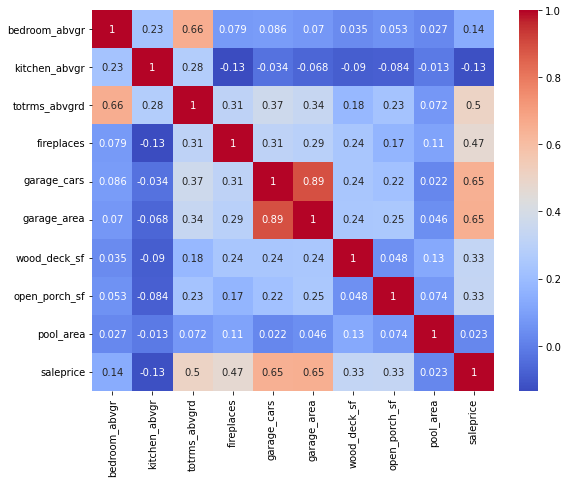

In [59]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(train[num_explore2].corr(), annot=True, cmap='coolwarm');

There is a strong enough correlation between salesprice and garage_cars or garage_area to further explore that. 

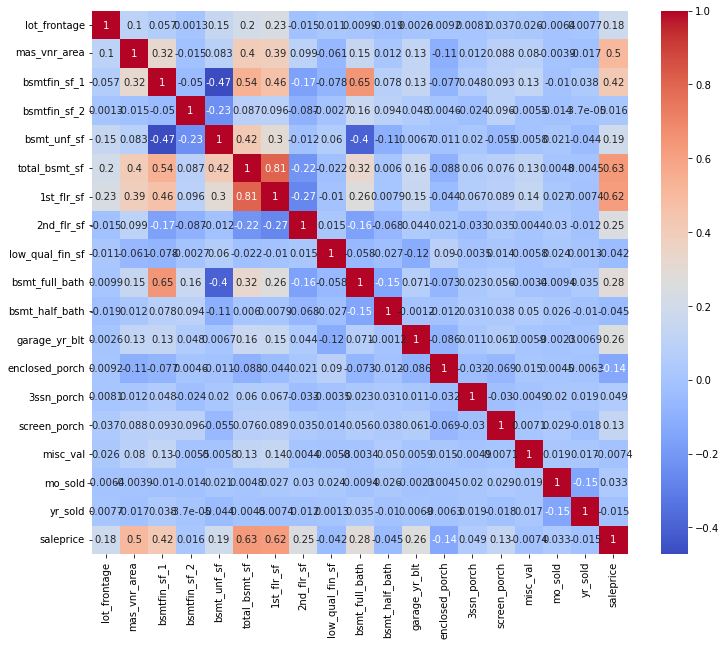

In [60]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(train[num_explore3].corr(), annot=True, cmap='coolwarm');

As I suspected the last list did not include greatly correlated features, except for total_bsmt_sf, and 1st_flr_sf

In [61]:
most_corr = ['overall_qual', 'gr_liv_area', 'garage_cars', 'total_bsmt_sf','1st_flr_sf', 'saleprice']

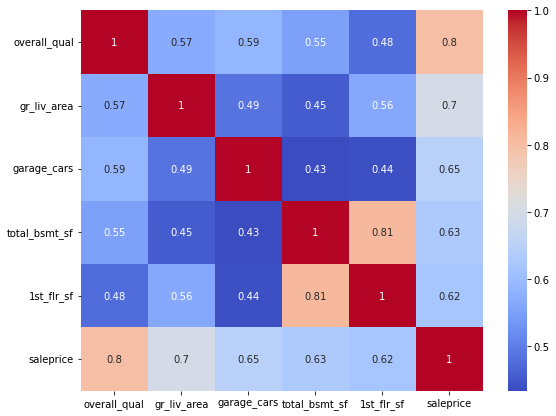

In [62]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(train[most_corr].corr(), annot=True, cmap='coolwarm')
plt.savefig('correlated_numerical');

Let's drop 'total_bsmt_sf' which seems to be captured by 1st_flr_sf anyway

#### Simple regression with numerical values that are highly correlated to saleprice

In [63]:
most_corr_2 = ['overall_qual', 'gr_liv_area', 'garage_cars', '1st_flr_sf']

In [64]:
X = train[most_corr_2]
y = train['saleprice']   

In [65]:
X.shape

(2051, 4)

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.80)

In [67]:
lr = LinearRegression() #instantiate the linear model
lr.fit(X_train, y_train)

LinearRegression()

In [68]:
lr.score(X_train, y_train)

0.7671548518912898

In [69]:
lr.score(X_val, y_val)

0.7910384729861552

Not bad, our simple model is accounting for about 79% of the variability in our target variable (in the val dataset). The model is not overfit, as we see that the score is slightly lower for the training data. 

In [70]:
list(zip(X_train.columns, lr.coef_))

[('overall_qual', 26468.928039269034),
 ('gr_liv_area', 36.95450276311432),
 ('garage_cars', 19698.31059295804),
 ('1st_flr_sf', 32.80847393840383)]

#### Let's explore how the variables selected in the simple model relates to the target

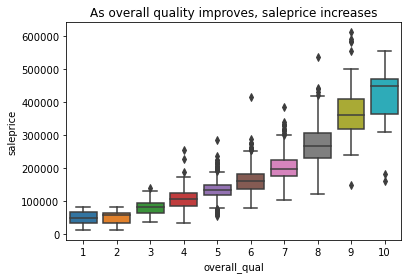

In [71]:
sns.boxplot(x=train['overall_qual'], y=train['saleprice'])
plt.title('As overall quality improves, saleprice increases');

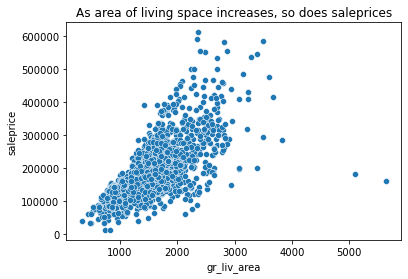

In [72]:
sns.scatterplot(x=train['gr_liv_area'], y=train['saleprice'])
plt.title('As area of living space increases, so does saleprices');

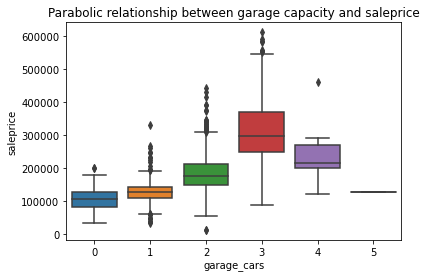

In [73]:
sns.boxplot(x=train['garage_cars'], y=train['saleprice'])
plt.title('Parabolic relationship between garage capacity and saleprice');

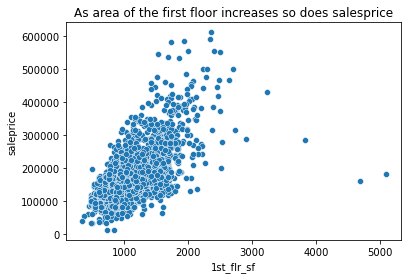

In [74]:
sns.scatterplot(x=train['1st_flr_sf'], y=train['saleprice'])
plt.title('As area of the first floor increases so does salesprice');

The scatterplots above show that a linear model may be capturing most of the relationship between the predictor variables and the target.

#### Let's do EDA on the rest of the ordinal columns 

In [75]:
ordinal_cols.append('saleprice')

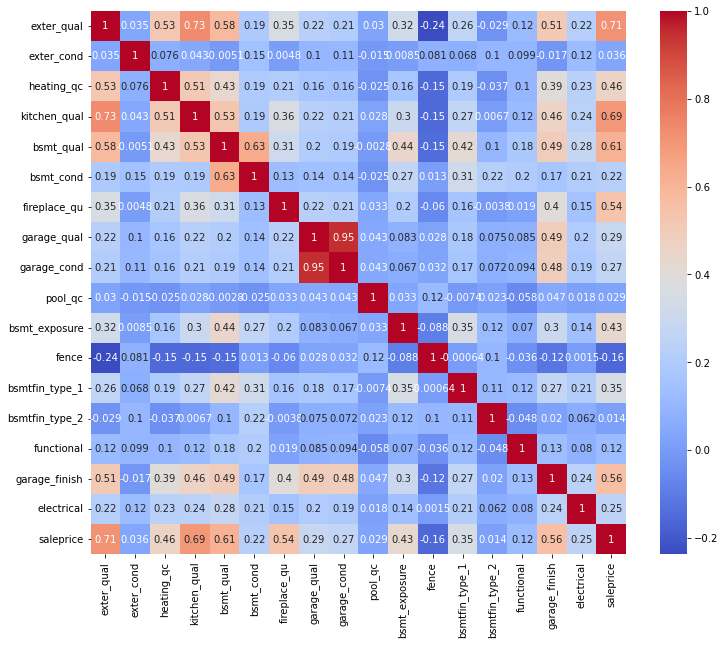

In [76]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(train[ordinal_cols].corr(), annot=True, cmap='coolwarm');

exter_qual, kitchen_qual, and bsmt_qual all look like good candidates to explore, and are relevant features for our clients who may be interested in remodeling their kitchens or basements. At the same time, I want our model to capture, how much of its price is due to the quality of the exterior of the house. 

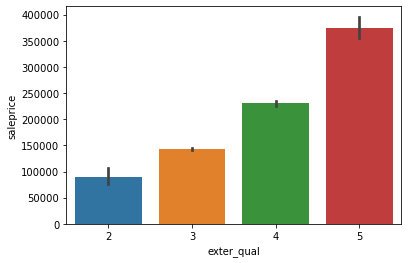

In [77]:
sns.barplot(x=train['exter_qual'], y=train['saleprice']);

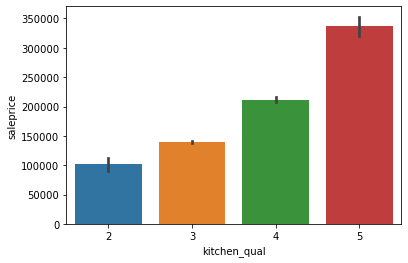

In [78]:
sns.barplot(x=train['kitchen_qual'], y=train['saleprice']);

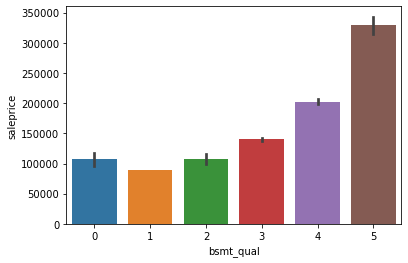

In [79]:
sns.barplot(x=train['bsmt_qual'], y=train['saleprice']);

There appears to be a relationship between these ordinal features and saleprice, so we will add them

In [80]:
add_ords = ['exter_qual', 'kitchen_qual', 'bsmt_qual']

''

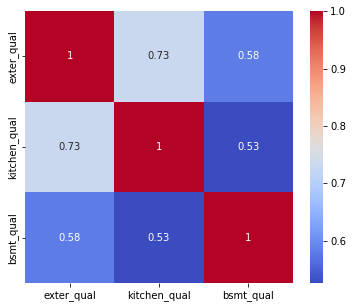

In [81]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(train[add_ords].corr(), annot=True, cmap='coolwarm')
;

In [82]:
feats_to_test = ['overall_qual', 'gr_liv_area', 'garage_cars', '1st_flr_sf'] + ['exter_qual', 'kitchen_qual', 'bsmt_qual']

In [83]:
X = train[feats_to_test]

In [84]:
y = train['saleprice']

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.80)

In [86]:
lr = LinearRegression() #instantiate the linear model
lr.fit(X_train, y_train)

LinearRegression()

In [87]:
lr.score(X_train, y_train)

0.8023715286871822

In [88]:
lr.score(X_val, y_val)

0.8197891907822659

In [89]:
list(zip(X_train.columns, lr.coef_))

[('overall_qual', 13369.832040910096),
 ('gr_liv_area', 37.45017069476924),
 ('garage_cars', 14613.62427206902),
 ('1st_flr_sf', 31.348163524376794),
 ('exter_qual', 20382.242544134944),
 ('kitchen_qual', 13267.2583641039),
 ('bsmt_qual', 10175.43625945461)]

The model did a slight improvement by adding the additional ordinal features. I would like to see if overall_qual is too closely correlated with the other quality features. If they are too related, it would degrade the explanatory power of the other quality-related variables. 

In [90]:
pred = lr.predict(X_val)

In [91]:
metrics.mean_absolute_error(y_val, pred)

23610.26315934947

This model, on average, misses the true sale price by 23,600 dollards

#### Looking at correlation between variables

In [92]:
test_corr = ['overall_qual', 'exter_qual', 'kitchen_qual', 'bsmt_qual']

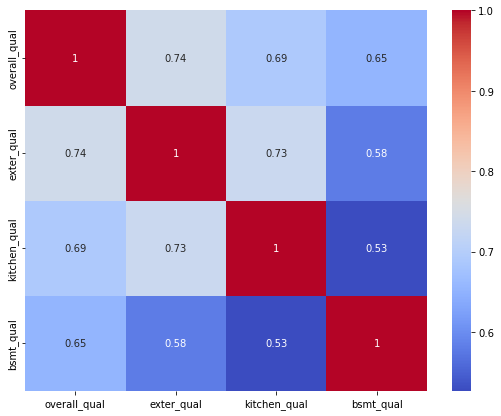

In [93]:
plt.figure(figsize=(9, 7))
ax = sns.heatmap(train[test_corr].corr(), annot=True, cmap='coolwarm');

No surprise, there is a strong the highest correlated feature is the overall_qual.

In [94]:
feats_to_test_2 = ['gr_liv_area', 'garage_cars', '1st_flr_sf','exter_qual', 'kitchen_qual', 'bsmt_qual']

In [95]:
X = train[feats_to_test_2]

In [96]:
y = train['saleprice']

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.80)

In [98]:
lr = LinearRegression() #instantiate the linear model
lr.fit(X_train, y_train)

LinearRegression()

In [99]:
lr.score(X_train, y_train)

0.7853269417069754

In [100]:
lr.score(X_val, y_val)

0.7998484237815895

In [101]:
list(zip(X_train.columns, lr.coef_))

[('gr_liv_area', 44.422729342412296),
 ('garage_cars', 17245.958355722258),
 ('1st_flr_sf', 33.92330509870226),
 ('exter_qual', 30198.312750704354),
 ('kitchen_qual', 18639.99673052161),
 ('bsmt_qual', 15609.027235605032)]

In [102]:
y_pred = lr.predict(X_val)

In [103]:
metrics.mean_absolute_error(y_val, y_pred)

25534.142865446214

Without the overall_qual feature the model is on average missing the sale price by 25,500 dollars

#### Generate OLS summary report to make sure those p-values are low!

In [104]:
X = train[feats_to_test]
X = sm.add_constant(X)
y = train['saleprice']

ols = sm.OLS(y, X).fit()

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [105]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1217.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:45:21   Log-Likelihood:                -24361.
No. Observations:                2051   AIC:                         4.874e+04
Df Residuals:                    2043   BIC:                         4.878e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.711e+05   4855.469    -35.233      0.000   -1.81e+05   -1.62e+05
overall_qual  1.369e+04   1002.624     13.653      0.000    1.17e+04    1.57e+04
gr_liv_area     39.8475      2.076     19.191      0.000      35.775      43.920
garage_cars   1.306e+04   1317.367      9.914      0.000    1.05e+04    1.56e+04
1st_flr_sf      33.1251      2.456     13.488      0.000      28.309      37.942
exter_qual    1.696e+04   2220.481      7.636      0.000    1.26e+04    2.13e+04
kitchen_qual  1.512e+04   1811.505      8.348      0.000    1.16e+04    1.87e+04
bsmt_qual     1.043e+04   1166.281      8.942      0.000    8142.176    1.27e+04
==============================================================================
Omnibus:                      677.906   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50097.465
Skew:                          -0.649   Prob(JB):                         0.00
Kurtosis:                      27.177   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values for all the variables are approximately 0, which is great! 

Below, let's see what happens if we eliminate overall_qual

In [106]:
feats_to_test_2 = ['gr_liv_area', 'garage_cars', '1st_flr_sf','exter_qual', 'kitchen_qual', 'bsmt_qual']

In [107]:
X = train[feats_to_test_2]
X = sm.add_constant(X)
y = train['saleprice']

ols = sm.OLS(y, X).fit()

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [108]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1273.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:45:21   Log-Likelihood:                -24451.
No. Observations:                2051   AIC:                         4.892e+04
Df Residuals:                    2044   BIC:                         4.896e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.781e+05   5041.956    -35.333      0.000   -1.88e+05   -1.68e+05
gr_liv_area     47.0997      2.096     22.467      0.000      42.988      51.211
garage_cars   1.595e+04   1357.980     11.744      0.000    1.33e+04    1.86e+04
1st_flr_sf      35.6512      2.558     13.939      0.000      30.635      40.667
exter_qual    2.703e+04   2187.307     12.357      0.000    2.27e+04    3.13e+04
kitchen_qual  2.027e+04   1850.392     10.957      0.000    1.66e+04    2.39e+04
bsmt_qual     1.598e+04   1141.643     13.997      0.000    1.37e+04    1.82e+04
==============================================================================
Omnibus:                      712.056   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46201.275
Skew:                          -0.777   Prob(JB):                         0.00
Kurtosis:                      26.199   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Analysis of the model so far and which variables to maintain

By eliminating overall_qual, we see a slight decrease in the R-square. But This is inconclusive as to whether the coefficients in our new model are better representing the relationships between price and the remaining variables. Perhaps the overall_qual variable is capturing other dimentions of quality not captured by the other three variables, which may explain that slight bump in the R-square score. 

However, the collinearity of overall_qual with the other variables can interfere with the model's ability to capture the relationship between the other quality variables and saleprice because overall_qual would create lots of noise. Because the purpose of this model is provide home sellers with actionable advice as to which features they can improve to boost sale price, I think it is best to drop overall_qual so that the model can better isolate the effects of each remaining variable. 

#### EDA in categorical columns

In [109]:
categorical_cols = [col for col in train.columns if col not in train_nums.columns]

In [110]:
len(categorical_cols)

26

We have 26 variables yet to be explored. Too many to individually inspect, I think it is best to use our understanding of home sales to narrow our exploration into the likely best predictor candidates. 

In [111]:
print(categorical_cols)

['ms_subclass', 'ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air', 'garage_type', 'paved_drive', 'misc_feature', 'sale_type']


In [112]:
cat_feats = ['ms_zoning', 'street', 'utilities', 'lot_config', 'neighborhood', 'condition', 'bldg_type', 'mas_vnr_type', 
             'heating', 'central_air', 'sale_condition']

##### Let's see what is going on with these categories

In [113]:
train.groupby('neighborhood').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice                
                       mean     min     max
neighborhood                               
MeadowV       100231.250000   73000  151400
IDOTRR        101103.188406   13100  202500
BrDale        103371.052632   85400  122500
OldTown       125276.300613   12789  475000
BrkSide       127022.697368   39300  223500
Edwards       130493.468531   35000  415000
SWISU         134758.875000   60000  200000
Landmrk       137000.000000  137000  137000
Sawyer        137181.909910   62383  219000
NPkVill       140476.470588  120000  155000
Blueste       144566.666667  121000  185000
NAmes         145905.816129   68000  345000
Mitchel       167656.707317   81500  300000
SawyerW       187760.160920   82000  320000
Greens        188666.666667  170000  206000
Gilbert       189228.387931  133000  377500
NWAmes        194619.022989  113000  306000
Blmngtn       200417.681818  159895  264561
CollgCr       202497.216667  110000  475000
Crawfor       205901.211268   90350  392500
ClearCr       217490.074074  130000  328000
Somerst       227183.900000  144152  468000
Timber        241051.354167  137500  425000
Veenker       253570.588235  150000  385000
GrnHill       280000.000000  230000  330000
NoRidge       316294.125000  190000  584500
NridgHt       322831.352459  154000  611657
StoneBr       329675.736842  130000  591587

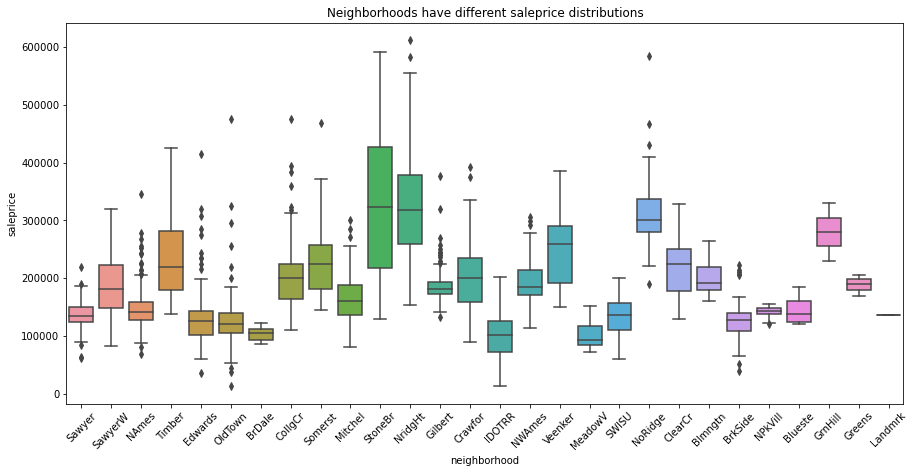

In [114]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=train['neighborhood'], y=train['saleprice'])
plt.xticks(rotation = 45)
plt.title('Neighborhoods have different saleprice distributions');

There is a difference in house prices by neighborhood, though we do not know if the diffences is due to the houses themselves or the desirability of the neighborhood. 

In [115]:
train.groupby('condition_1').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice                
                      mean     min     max
condition_1                               
Artery       128765.000000   50000  475000
RRNe         129616.666667   93850  169000
RRAe         139685.714286   87000  184000
Feedr        143223.605505   35000  269500
RRAn         172604.777778   79500  336820
Norm         185007.310130   12789  611657
RRNn         198208.333333  128000  320000
PosA         254733.333333  185000  455000
PosN         254794.296296  109500  591587

Home that are PosA (adjacent to positie off-site feature) and those PosN (Near positive off-site feature) see a huge bump in their average saleprice 

In [116]:
train.groupby('ms_zoning').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice                
                    mean     min     max
ms_zoning                               
A (agr)     47300.000000   13100   81500
I (all)     57625.000000   57625   57625
C (all)     78010.894737   34900  140000
RM         129119.142405   12789  475000
RH         148859.571429   82000  200000
RL         191235.164581   35000  611657
FV         218618.316832  144152  370878

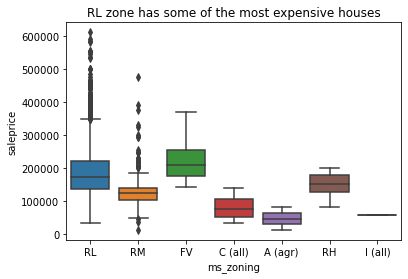

In [117]:
sns.boxplot(x=train['ms_zoning'], y=train['saleprice'])
plt.title('RL zone has some of the most expensive houses');

Homes in the FV (floating village residential zone) see significant bump in price

In [118]:
train.groupby('bldg_type').mean()[['saleprice']].sort_values(by='saleprice').round(2)

,saleprice
bldg_type,
2fmCon,123179.89
Twnhs,133100.00
Duplex,139296.33
1Fam,185275.69
TwnhsE,198312.37


In [119]:
train.groupby('mas_vnr_type').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice                
                       mean     min     max
mas_vnr_type                               
BrkCmn        144515.692308   82500  277000
None          153679.275862   12789  475000
BrkFace       212161.436508   75000  591587
              234932.772727  117250  465000
Stone         263714.702381   99000  611657

In [120]:
pd.set_option('display.max_columns', None)
train[train['mas_vnr_type']=='']

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
22,2393,528142010,60,RL,103,12867,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2005,2006,Gable,CompShg,CemntBd,CmentBd,,0,4,3,PConc,5,3,3,1,0,1,0,1209,1209,GasA,5,Y,5,1209,1044,0,2253,0,0,2,1,3,1,5,8,8,1,4,Attchd,2005,3,2,575,3,3,Y,243,142,0,0,0,0,0,0,NA,0,7,2006,New,344133
41,2383,528110050,20,RL,107,13891,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,,0,5,3,PConc,5,4,4,6,1386,1,0,690,2076,GasA,5,Y,5,2076,0,0,2076,1,0,2,1,2,1,5,7,8,1,4,Attchd,2006,3,3,850,3,3,Y,216,229,0,0,0,0,0,0,NA,0,9,2006,New,465000
86,539,531371050,20,RL,67,10083,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,,0,4,3,PConc,4,3,1,6,833,1,0,343,1176,GasA,5,Y,5,1200,0,0,1200,1,0,2,0,2,1,4,5,8,0,0,Attchd,2003,2,2,555,3,3,Y,0,41,0,0,0,0,0,0,NA,0,8,2009,WD,184900
212,518,528458020,20,FV,90,7993,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,CompShg,VinylSd,VinylSd,,0,4,3,PConc,5,3,1,1,0,1,0,1436,1436,GasA,5,Y,5,1436,0,0,1436,0,0,2,0,3,1,4,6,8,0,0,Attchd,2008,3,2,529,3,3,Y,0,121,0,0,0,0,0,0,NA,0,10,2009,New,225000
276,2824,908130020,20,RL,75,8050,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,,0,3,3,PConc,4,3,3,6,475,5,297,142,914,GasA,5,Y,5,914,0,0,914,1,0,1,0,2,1,4,4,8,0,0,NA,0,0,0,0,0,0,N,32,0,0,0,0,0,0,0,NA,0,4,2006,WD,117250
338,1800,528458150,60,FV,112,12217,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2007,2007,Hip,CompShg,WdShing,Wd Shng,,0,4,3,PConc,5,3,3,6,745,1,0,210,955,GasA,5,Y,5,955,925,0,1880,1,0,2,1,3,1,5,8,8,1,4,Attchd,2007,3,3,880,3,3,Y,168,127,0,0,0,0,0,0,NA,0,12,2007,New,310013
431,1455,907251090,60,RL,75,9473,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,,0,4,3,PConc,4,3,1,6,804,1,0,324,1128,GasA,5,Y,5,1128,903,0,2031,1,0,2,1,3,1,4,7,8,1,4,Attchd,2002,2,2,577,3,3,Y,0,211,0,0,0,0,0,0,NA,0,3,2008,WD,237000
451,1120,528439010,20,RL,87,10037,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Feedr,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,,0,4,3,PConc,5,3,1,6,666,1,0,794,1460,GasA,5,Y,5,1460,0,0,1460,0,0,2,0,3,1,4,6,8,1,4,Attchd,2006,3,2,480,3,3,Y,0,20,0,0,0,0,0,0,NA,0,8,2008,WD,247000
591,1841,533208040,120,FV,35,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,,0,4,3,PConc,4,3,1,6,1106,1,0,135,1241,GasA,5,Y,5,1241,0,0,1241,1,0,1,1,1,1,4,4,8,0,0,Attchd,2007,3,2,569,3,3,Y,0,116,0,0,0,0,0,0,NA,0,11,2007,New,199900
844,1840,533208030,120,FV,30,5330,Pave,Pave,IR2,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,8,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,,0,4,3,PConc,4,3,1,1,0,1,0,1550,1550,GasA,5,Y,5,1550,0,0,1550,0,0,2,1,2,1,4,5,8,0,0,Attchd,2007,3,2,528,3,3,Y,0,102,0,0,0,0,0,0,NA,0,7,2007,New,207500


The empty strings in 'mas_vnr_type' means None because the 'mas_vnr_area' in those entries suggests there is no veneer, let's fix that for train and test

In [121]:
train['mas_vnr_type'] = train['mas_vnr_type'].replace('', 'None')

In [122]:
test['mas_vnr_type'] = test['mas_vnr_type'].replace('', 'None')

In [123]:
sum(train['mas_vnr_type']=='')

0

In [124]:
sum(test['mas_vnr_type']=='')

0

In [125]:
train.groupby('mas_vnr_type').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice               
                       mean    min     max
mas_vnr_type                              
BrkCmn        144515.692308  82500  277000
None          155120.870161  12789  475000
BrkFace       212161.436508  75000  591587
Stone         263714.702381  99000  611657

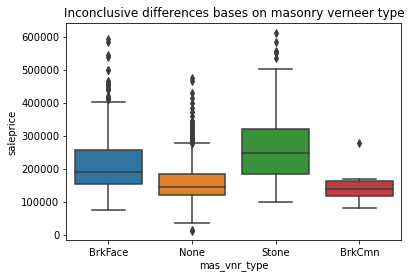

In [126]:
sns.boxplot(x=train['mas_vnr_type'], y=train['saleprice'])
plt.title('Inconclusive differences bases on masonry verneer type');

In [127]:
train.groupby('heating').mean()[['saleprice']].sort_values(by='saleprice').round(2)

,saleprice
heating,
Grav,65180.00
Wall,77150.00
OthW,125750.00
GasW,151275.00
GasA,182422.48


In [128]:
train.groupby('central_air').agg({'saleprice': ['mean', 'min', 'max']}).sort_values(by=('saleprice', 'mean'))

saleprice               
                      mean    min     max
central_air                              
N            100575.078014  12789  239000
Y            187441.503665  50000  611657

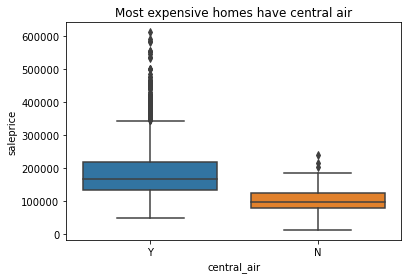

In [129]:
sns.boxplot(x=train['central_air'], y=train['saleprice'])
plt.title('Most expensive homes have central air');

I will selected just a few of the categorical features above to add to our regression model. I will use OHE to encode these features. 

#### Adding categorical features to our model

In [130]:
cat_feats_selected = ['neighborhood', 'mas_vnr_type', 'central_air', 'condition_1']

In [131]:
for col in cat_feats_selected: 
    print(col, sum(train[col]==''))

neighborhood 0
mas_vnr_type 0
central_air 0
condition_1 0


In [132]:
all_feats = feats_to_test_2 + cat_feats_selected

In [133]:
X = train[all_feats]
y = train['saleprice']

In [134]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.8)

**Let's OneHotEncode!**

In [135]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [136]:
smart_encoder = make_column_transformer(
    (ohe, cat_feats_selected), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [137]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['neighborhood', 'mas_vnr_type', 'central_air',
                                  'condition_1'])],
                  verbose_feature_names_out=False)

In [138]:
X_train_enc = smart_encoder.transform(X_train)

In [139]:
X_val_enc = smart_encoder.transform(X_val)

In [140]:
lr = LinearRegression()

In [141]:
lr.fit(X_train_enc, y_train)

LinearRegression()

In [142]:
lr.score(X_train_enc, y_train)

0.8312888592897412

In [143]:
lr.score(X_val_enc, y_val)

0.8144690057543872

#### Analysis of our newer model


Despite adding a few more categories, the model seems to be only slightly overfit, and had experienced a slight improvement in the R-squared score. I think by adding to the model the properly location (neighborhood), the desirability of the area (condition), external features that can add value (masonry veneer), and whether it has central air, the model can better isolate the effect of vsriables we previously tested on price. I think that although the R-squared score remains similar, the fact that we have not added much variability to the model while adding more features makes this a more desirable model than the one we have above. 

In [144]:
list(zip(smart_encoder.get_feature_names_out(), lr.coef_))

[('neighborhood_Blueste', -870.6526827061205),
 ('neighborhood_BrDale', -3250.868942776763),
 ('neighborhood_BrkSide', 7851.46923401194),
 ('neighborhood_ClearCr', 44245.21355680068),
 ('neighborhood_CollgCr', 15780.138515129993),
 ('neighborhood_Crawfor', 34069.874976799314),
 ('neighborhood_Edwards', -1320.2343341046824),
 ('neighborhood_Gilbert', 13764.942462579651),
 ('neighborhood_Greens', 19061.203626517963),
 ('neighborhood_GrnHill', 121437.51857415306),
 ('neighborhood_IDOTRR', -1734.4719851190605),
 ('neighborhood_Landmrk', 2388.090056703969),
 ('neighborhood_MeadowV', -7268.141075441672),
 ('neighborhood_Mitchel', 13498.34044356723),
 ('neighborhood_NAmes', 12713.48957207918),
 ('neighborhood_NPkVill', 4027.1724058280283),
 ('neighborhood_NWAmes', 11470.049475506723),
 ('neighborhood_NoRidge', 55769.87750990761),
 ('neighborhood_NridgHt', 71911.07971354842),
 ('neighborhood_OldTown', -2214.621547690612),
 ('neighborhood_SWISU', 9158.989730440559),
 ('neighborhood_Sawyer', 139

The coefficients for the model with only numerical and ordinal variables:

[('gr_liv_area', 44.422729342412296),
 ('garage_cars', 17245.958355722258),
 ('1st_flr_sf', 33.92330509870226),
 ('exter_qual', 30198.312750704354),
 ('kitchen_qual', 18639.99673052161),
 ('bsmt_qual', 15609.027235605032)]

In [145]:
val_pred = lr.predict(X_val_enc)

In [146]:
metrics.mean_absolute_error(y_val, val_pred)

23198.31248044801

This is the best MAE value that we have gotten so far. 

### Using Lasso to select variables:

I am going to see if passing all variables to lasso will help us isolate the best variables for our model. 

In [147]:
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289,4,3,CBlock,3,3,1,6,533,1,0,192,725,GasA,5,Y,5,725,754,0,1479,0,0,2,1,3,1,4,6,8,0,0,Attchd,1976,2,2,475,3,3,Y,0,44,0,0,0,0,0,0,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132,4,3,PConc,4,3,1,6,637,1,0,276,913,GasA,5,Y,5,913,1209,0,2122,1,0,2,1,4,1,4,8,8,1,3,Attchd,1997,2,2,559,3,3,Y,0,74,0,0,0,0,0,0,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0,3,4,CBlock,3,3,1,6,731,1,0,326,1057,GasA,3,Y,5,1057,0,0,1057,1,0,1,0,3,1,4,5,8,0,0,Detchd,1953,1,1,246,3,3,Y,0,52,0,0,0,0,0,0,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0,3,3,PConc,4,3,1,1,0,1,0,384,384,GasA,4,Y,5,744,700,0,1444,0,0,2,1,3,1,3,7,8,0,0,BuiltIn,2007,3,2,400,3,3,Y,100,0,0,0,0,0,0,0,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0,3,3,PConc,2,4,1,1,0,1,0,676,676,GasA,3,Y,5,831,614,0,1445,0,0,2,0,3,1,3,6,8,0,0,Detchd,1957,1,2,484,3,3,N,0,59,0,0,0,0,0,0,NA,0,3,2010,WD,138500


In [148]:
X = train.drop(columns=['saleprice', 'id', 'pid'])

y = train['saleprice']

In [149]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.8)

In [150]:
train_num_cols = X_train._get_numeric_data().columns

In [151]:
train_num_cols

Index(['lot_frontage', 'lot_area', 'overall_qual', 'overall_cond',
       'year_built', 'year_remod/add', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating_qc', 'electrical',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_yr_blt',
       'garage_finish', 'garage_cars', 'garage_area', 'garage_qual',
       'garage_cond', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       '3ssn_porch', 'screen_porch', 'pool_area', 'pool_qc', 'fence',
       'misc_val', 'mo_sold', 'yr_sold'],
      dtype='object')

In [152]:
categorical = [col for col in X_train.columns if col not in train_num_cols and col != 'id' and col != 'pid']

In [153]:
categorical

['ms_subclass',
 'ms_zoning',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition_1',
 'condition_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'exterior_1st',
 'exterior_2nd',
 'mas_vnr_type',
 'foundation',
 'heating',
 'central_air',
 'garage_type',
 'paved_drive',
 'misc_feature',
 'sale_type']

In [154]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [155]:
smart_encoder = make_column_transformer(
    (ohe, categorical), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [156]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['ms_subclass', 'ms_zoning', 'street', 'alley',
                                  'lot_shape', 'land_contour', 'utilities',
                                  'lot_config', 'land_slope', 'neighborhood',
                                  'condition_1', 'condition_2', 'bldg_type',
                                  'house_style', 'roof_style', 'roof_matl',
                                  'exterior_1st', 'exterior_2nd',
                                  'mas_vnr_type', 'foundation', 'heating',
                                  'central_air', 'garage_type', 'paved_drive',
                                  'misc_feature', 'sale_type'])],
                  verbose_feature_name

In [157]:
X_train_enc = smart_encoder.transform(X_train)

In [158]:
X_val_enc = smart_encoder.transform(X_val)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [159]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_enc)
X_val_ss = ss.transform(X_val_enc)

Lasso time

In [160]:
l_alphas = np.arange(0.01, 10.0, 0.05)

In [161]:
lasso_cv = LassoCV(cv=10, tol=.0003).fit(X_train_ss, y_train)

In [162]:
print('best alpha:', lasso_cv.alpha_)
print('score:', lasso_cv.score(X_train_ss, y_train))

best alpha: 838.0196764504936
score: 0.9001198043851535


In [163]:
new_lasso = Lasso(alpha = lasso_cv.alpha_)

In [164]:
new_lasso.fit(X_train_ss, y_train)

Lasso(alpha=838.0196764504936)

In [165]:
new_lasso.score(X_val_ss, y_val)

0.8770341445826499

In [166]:
final_columns = [col for col, coef in zip (X.columns, new_lasso.coef_) if coef] + ['saleprice']

I am adding saleprice so that I can use the list for another modeling cycle

In [167]:
len(final_columns)

35

#### Analysis after first lasso

The score improved after running lasso, but I did not get lasso to converge at the default tolerance level. I will run lasso again with the features that have been isolated above and see if the problem was an over-selection of features. 


#### 2nd Lasso cycle

In [168]:
lasso_train = train.loc[:, final_columns]

In [169]:
lasso_train.head()

,ms_subclass,ms_zoning,lot_area,street,alley,house_style,roof_style,exterior_1st,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_cond,bsmtfin_type_1,bsmtfin_type_2,bsmt_unf_sf,electrical,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_half_bath,totrms_abvgrd,fireplaces,fireplace_qu,garage_type,garage_area,garage_qual,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,mo_sold,sale_type,saleprice
0,60,RL,13517,Pave,NA,2Story,Gable,HdBoard,BrkFace,289,3,CBlock,3,6,1,192,5,754,0,1479,0,6,0,0,Attchd,475,3,0,44,0,0,0,3,WD,130500
1,60,RL,11492,Pave,NA,2Story,Gable,VinylSd,BrkFace,132,3,PConc,3,6,1,276,5,1209,0,2122,0,8,1,3,Attchd,559,3,0,74,0,0,0,4,WD,220000
2,20,RL,7922,Pave,NA,1Story,Gable,VinylSd,None,0,4,CBlock,3,6,1,326,5,0,0,1057,0,5,0,0,Detchd,246,3,0,52,0,0,0,1,WD,109000
3,60,RL,9802,Pave,NA,2Story,Gable,VinylSd,None,0,3,PConc,3,1,1,384,5,700,0,1444,0,7,0,0,BuiltIn,400,3,100,0,0,0,0,4,WD,174000
4,50,RL,14235,Pave,NA,1.5Fin,Gable,Wd Sdng,None,0,3,PConc,4,1,1,676,5,614,0,1445,0,6,0,0,Detchd,484,3,0,59,0,0,0,3,WD,138500


In [170]:
lasso_train.shape

(2051, 35)

In [171]:
num_cols =lasso_train._get_numeric_data().columns

In [172]:
cat_cols = [col for col in lasso_train.columns if col not in num_cols]

In [173]:
print(len(num_cols))
print(len(cat_cols))

24
11


In [174]:
X = lasso_train.drop(columns='saleprice')
y = lasso_train['saleprice']

In [175]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.8)

In [176]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [177]:
smart_encoder = make_column_transformer(
    (ohe, cat_cols),
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [178]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['ms_subclass', 'ms_zoning', 'street', 'alley',
                                  'house_style', 'roof_style', 'exterior_1st',
                                  'mas_vnr_type', 'foundation', 'garage_type',
                                  'sale_type'])],
                  verbose_feature_names_out=False)

In [179]:
X_train_enc = smart_encoder.transform(X_train)

In [180]:
X_val_enc = smart_encoder.transform(X_val)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [181]:
X_train_enc = pd.DataFrame(X_train_enc, columns=smart_encoder.get_feature_names_out())

In [182]:
X_val_enc = pd.DataFrame(X_val_enc, columns=smart_encoder.get_feature_names_out())

In [183]:
num_cols = list(num_cols)

In [184]:
num_cols.remove('saleprice')

In [185]:
ss = StandardScaler()

smart_scaler = make_column_transformer(
    (ss, num_cols), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [186]:
smart_scaler.fit(X_train_enc)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['lot_area', 'mas_vnr_area', 'exter_cond',
                                  'bsmt_cond', 'bsmtfin_type_1',
                                  'bsmtfin_type_2', 'bsmt_unf_sf', 'electrical',
                                  '2nd_flr_sf', 'low_qual_fin_sf',
                                  'gr_liv_area', 'bsmt_half_bath',
                                  'totrms_abvgrd', 'fireplaces', 'fireplace_qu',
                                  'garage_area', 'garage_qual', 'wood_deck_sf',
                                  'open_porch_sf', 'enclosed_porch',
                                  '3ssn_porch', 'screen_porch', 'mo_sold'])],
                  verbose_feature_names_out=False)

In [187]:
X_train_ss = smart_scaler.transform(X_train_enc)

In [188]:
X_val_ss = smart_scaler.transform(X_val_enc)

In [189]:
X_train_ss = pd.DataFrame(X_train_ss, columns=smart_scaler.get_feature_names_out())

In [190]:
X_val_ss = pd.DataFrame(X_val_ss, columns=smart_scaler.get_feature_names_out())

In [191]:
print(X_train_ss.shape, X_val_ss.shape)

(1640, 94) (411, 94)


Lasso again with more narrow selection of columns

In [192]:
lasso_cv = LassoCV(cv=10).fit(X_train_ss, y_train)

In [193]:
print('best alpha:', lasso_cv.alpha_)
print('score:', lasso_cv.score(X_train_ss, y_train))

best alpha: 63.199622418132755
score: 0.8001764295228946


In [194]:
new_lasso = Lasso(alpha = lasso_cv.alpha_)

In [195]:
new_lasso.fit(X_train_ss, y_train)

Lasso(alpha=63.199622418132755)

In [196]:
new_lasso.score(X_val_ss, y_val)

0.8247901912511035

In [197]:
final_columns = [col for col, coef in zip (X.columns, new_lasso.coef_) if coef] + ['saleprice']

In [198]:
final_columns

['ms_subclass',
 'ms_zoning',
 'lot_area',
 'street',
 'alley',
 'house_style',
 'roof_style',
 'exterior_1st',
 'mas_vnr_type',
 'mas_vnr_area',
 'exter_cond',
 'foundation',
 'bsmt_cond',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'bsmt_unf_sf',
 'electrical',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_half_bath',
 'totrms_abvgrd',
 'garage_type',
 'garage_area',
 'garage_qual',
 'wood_deck_sf',
 'open_porch_sf',
 '3ssn_porch',
 'mo_sold',
 'sale_type',
 'saleprice']

In [199]:
len(final_columns)

31

#### Analysis after 2nd lasso

In the 2nd lasso I decided to not standardize my dummy variables, and to use the 'left-over' features from the first lasso. I was successful in getting lasso to converge at the default tolerance level, but the model score did not improve! 

Nonetheless, I think I should take a closer look at the left-over features from the second lasso, to see if I can improve the explanatory power of my first regression model by adding some of lasso-isolated features

#### Linear regression with added features from lasso 

Below, I will be adding features to my linear regression model based on the results from lasso, and also paying a closer attention to features that clients would be interested in renovating for the purpose of increasing their sale price. 

In [200]:
additional_feats = ['fireplace_qu', 'wood_deck_sf', 'electrical', 'exter_cond', 'street', 'paved_drive',
                    'lot_area', 'fence', 'roof_style','bsmt_cond', 'bsmtfin_type_1','ms_zoning',
                    'exterior_1st','totrms_abvgrd', 'low_qual_fin_sf', 'garage_qual']

In [201]:
train[all_feats].head()

,gr_liv_area,garage_cars,1st_flr_sf,exter_qual,kitchen_qual,bsmt_qual,neighborhood,mas_vnr_type,central_air,condition_1
0,1479,2,725,4,4,3,Sawyer,BrkFace,Y,RRAe
1,2122,2,913,4,4,4,SawyerW,BrkFace,Y,Norm
2,1057,1,1057,3,4,3,NAmes,None,Y,Norm
3,1444,2,744,3,3,4,Timber,None,Y,Norm
4,1445,2,831,3,3,2,SawyerW,None,Y,Norm


In [202]:
train[additional_feats].head()

,fireplace_qu,wood_deck_sf,electrical,exter_cond,street,paved_drive,lot_area,fence,roof_style,bsmt_cond,bsmtfin_type_1,ms_zoning,exterior_1st,totrms_abvgrd,low_qual_fin_sf,garage_qual
0,0,0,5,3,Pave,Y,13517,0,Gable,3,6,RL,HdBoard,6,0,3
1,3,0,5,3,Pave,Y,11492,0,Gable,3,6,RL,VinylSd,8,0,3
2,0,0,5,4,Pave,Y,7922,0,Gable,3,6,RL,VinylSd,5,0,3
3,0,100,5,3,Pave,Y,9802,0,Gable,3,1,RL,VinylSd,7,0,3
4,0,0,5,3,Pave,N,14235,0,Gable,4,1,RL,Wd Sdng,6,0,3


In [203]:
cat_feats = ['neighborhood', 'mas_vnr_type', 'central_air', 'condition_1',
             'street', 'paved_drive','roof_style','ms_zoning', 'exterior_1st']

In [204]:
discrete_feats = ['garage_cars', 'exter_qual', 'kitchen_qual', 'fireplace_qu',
                  'exter_cond', 'fence','bsmt_cond', 'bsmtfin_type_1', 'totrms_abvgrd', 
                  'garage_qual', 'electrical']

In [205]:
continuous_feats = ['gr_liv_area', '1st_flr_sf', 'wood_deck_sf', 'lot_area','low_qual_fin_sf']

In [206]:
all_feats = cat_feats + discrete_feats + continuous_feats

In [207]:
len(all_feats)

25

In [208]:
X = train[all_feats]

In [209]:
X.head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,garage_cars,exter_qual,kitchen_qual,fireplace_qu,exter_cond,fence,bsmt_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,lot_area,low_qual_fin_sf
0,Sawyer,BrkFace,Y,RRAe,Pave,Y,Gable,RL,HdBoard,2,4,4,0,3,0,3,6,6,3,5,1479,725,0,13517,0
1,SawyerW,BrkFace,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,4,4,3,3,0,3,6,8,3,5,2122,913,0,11492,0
2,NAmes,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,1,3,4,0,4,0,3,6,5,3,5,1057,1057,0,7922,0
3,Timber,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,3,3,0,3,0,3,1,7,3,5,1444,744,100,9802,0
4,SawyerW,None,Y,Norm,Pave,N,Gable,RL,Wd Sdng,2,3,3,0,3,0,4,1,6,3,5,1445,831,0,14235,0


In [210]:
y = train['saleprice']

In [211]:
for col in all_feats: 
    print(col, sum(train[col]==''))

neighborhood 0
mas_vnr_type 0
central_air 0
condition_1 0
street 0
paved_drive 0
roof_style 0
ms_zoning 0
exterior_1st 0
garage_cars 0
exter_qual 0
kitchen_qual 0
fireplace_qu 0
exter_cond 0
fence 0
bsmt_cond 0
bsmtfin_type_1 0
totrms_abvgrd 0
garage_qual 0
electrical 0
gr_liv_area 0
1st_flr_sf 0
wood_deck_sf 0
lot_area 0
low_qual_fin_sf 0


In [212]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.8)

In [213]:
X_train.head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,garage_cars,exter_qual,kitchen_qual,fireplace_qu,exter_cond,fence,bsmt_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,lot_area,low_qual_fin_sf
480,StoneBr,BrkFace,Y,Norm,Pave,Y,Hip,RL,VinylSd,2,4,4,4,3,0,4,6,7,3,5,2234,2234,390,14082,0
1200,Mitchel,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,3,3,0,4,0,3,5,5,3,5,1080,1080,120,9187,0
1215,NPkVill,None,Y,Norm,Pave,Y,Gable,RL,Plywood,2,3,3,1,3,0,3,5,4,3,5,1069,1069,0,4043,0
278,Blueste,None,Y,Norm,Pave,Y,Gable,RM,MetalSd,2,3,3,3,4,4,3,2,6,3,5,1556,716,161,1950,0
1925,NWAmes,BrkFace,Y,Norm,Pave,Y,Gable,RL,MetalSd,2,4,4,3,4,0,3,4,7,3,5,1440,1440,0,12546,0


**Let's OneHotEncode!**

In [214]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [215]:
smart_encoder = make_column_transformer(
    (ohe, cat_feats), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [216]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['neighborhood', 'mas_vnr_type', 'central_air',
                                  'condition_1', 'street', 'paved_drive',
                                  'roof_style', 'ms_zoning', 'exterior_1st'])],
                  verbose_feature_names_out=False)

In [217]:
X_train_enc = smart_encoder.transform(X_train)

In [218]:
X_val_enc = smart_encoder.transform(X_val)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [219]:
smart_encoder.get_feature_names_out()

array(['neighborhood_Blueste', 'neighborhood_BrDale',
       'neighborhood_BrkSide', 'neighborhood_ClearCr',
       'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert',
       'neighborhood_Greens', 'neighborhood_GrnHill',
       'neighborhood_IDOTRR', 'neighborhood_Landmrk',
       'neighborhood_MeadowV', 'neighborhood_Mitchel',
       'neighborhood_NAmes', 'neighborhood_NPkVill',
       'neighborhood_NWAmes', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_OldTown',
       'neighborhood_SWISU', 'neighborhood_Sawyer',
       'neighborhood_SawyerW', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'neighborhood_Timber',
       'neighborhood_Veenker', 'mas_vnr_type_BrkFace',
       'mas_vnr_type_None', 'mas_vnr_type_Stone', 'central_air_Y',
       'condition_1_Feedr', 'condition_1_Norm', 'condition_1_PosA',
       'condition_1_PosN', 'condition_1_RRAe', 'condition_1_RRAn',
       'condition_1_RRNe', 'condition_

In [220]:
lr = LinearRegression()

In [221]:
lr.fit(X_train_enc, y_train)

LinearRegression()

In [222]:
lr.score(X_train_enc, y_train)

0.8490750029491435

In [223]:
lr.score(X_val_enc, y_val)

0.8406169375005275

Adding the lasso features improved my model's score, and hopefully it is helping to isolate the effects of each variable better than my previous LR model

In [224]:
val_pred = lr.predict(X_val_enc)

In [225]:
residuals = y_val - val_pred

In [226]:
metrics.mean_absolute_error(y_val, val_pred)

21287.55777581252

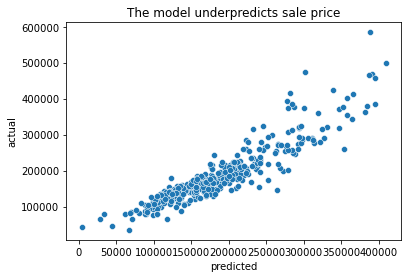

In [227]:
sns.scatterplot(x=val_pred, y=y_val)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('The model underpredicts sale price');
plt.savefig('actual_predicted_1');

Comparing predicted vs actual prices, the model does not look so bad, however, it seems that my model is underestimating house prices.

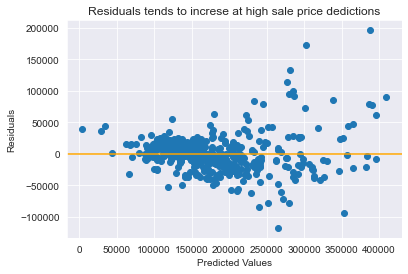

In [228]:
sns.set_style("darkgrid")
plt.scatter(val_pred, residuals)
plt.axhline(0, color='orange')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals tends to increse at high sale price dedictions')
plt.savefig('residuals4');

With the lower sale prices, the residuals stays a little tight around 0, however, at the higher sale prices, the model is not doing a good job at explaining the variability in price. 

Once possibility is that the features I have isolated make up a smaller proportion of the overall house price so it cannot properly explain the overall price for more expensive houses. 

In [229]:
mse = metrics.mean_squared_error(y_val, val_pred)
np.sqrt(mse)

31624.880606261446

In [230]:
list(zip(smart_encoder.get_feature_names_out(), lr.coef_))

[('neighborhood_Blueste', 3937.328198330095),
 ('neighborhood_BrDale', 7109.606440928031),
 ('neighborhood_BrkSide', 11071.75673685428),
 ('neighborhood_ClearCr', 28240.8228184211),
 ('neighborhood_CollgCr', 14197.69555769724),
 ('neighborhood_Crawfor', 24063.999083678784),
 ('neighborhood_Edwards', -6176.315131637079),
 ('neighborhood_Gilbert', 9866.576001362211),
 ('neighborhood_Greens', 22820.283282806307),
 ('neighborhood_GrnHill', 125402.89210918907),
 ('neighborhood_IDOTRR', 9743.359435433153),
 ('neighborhood_Landmrk', -14582.526184576906),
 ('neighborhood_MeadowV', -21286.493059644083),
 ('neighborhood_Mitchel', 12617.892432892186),
 ('neighborhood_NAmes', 4714.266897436119),
 ('neighborhood_NPkVill', 6137.345437771108),
 ('neighborhood_NWAmes', 8329.474568448835),
 ('neighborhood_NoRidge', 51417.787174516874),
 ('neighborhood_NridgHt', 68559.60138196679),
 ('neighborhood_OldTown', 1232.8126237603246),
 ('neighborhood_SWISU', 4528.4099275845665),
 ('neighborhood_Sawyer', 5942.7

#### Using Lasso to refind selected features and decrease multicollinearity

Although my model above has an improved R-square, I am going to double check for multicollinearity and see if we can refine the model even further. 

In [231]:
X = train[all_feats]

In [232]:
y = train['saleprice']

In [233]:
X.head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,garage_cars,exter_qual,kitchen_qual,fireplace_qu,exter_cond,fence,bsmt_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,lot_area,low_qual_fin_sf
0,Sawyer,BrkFace,Y,RRAe,Pave,Y,Gable,RL,HdBoard,2,4,4,0,3,0,3,6,6,3,5,1479,725,0,13517,0
1,SawyerW,BrkFace,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,4,4,3,3,0,3,6,8,3,5,2122,913,0,11492,0
2,NAmes,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,1,3,4,0,4,0,3,6,5,3,5,1057,1057,0,7922,0
3,Timber,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,3,3,0,3,0,3,1,7,3,5,1444,744,100,9802,0
4,SawyerW,None,Y,Norm,Pave,N,Gable,RL,Wd Sdng,2,3,3,0,3,0,4,1,6,3,5,1445,831,0,14235,0


In [234]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=29, train_size=.8)

In [235]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [236]:
smart_encoder = make_column_transformer(
    (ohe, cat_feats),
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [237]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['neighborhood', 'mas_vnr_type', 'central_air',
                                  'condition_1', 'street', 'paved_drive',
                                  'roof_style', 'ms_zoning', 'exterior_1st'])],
                  verbose_feature_names_out=False)

In [238]:
X_train_enc = smart_encoder.transform(X_train)

In [239]:
X_val_enc = smart_encoder.transform(X_val)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [240]:
X_train_enc = pd.DataFrame(X_train_enc, columns=smart_encoder.get_feature_names_out())

In [241]:
X_val_enc = pd.DataFrame(X_val_enc, columns=smart_encoder.get_feature_names_out())

In [242]:
ss = StandardScaler()

smart_scaler = make_column_transformer(
    (ss, continuous_feats+discrete_feats), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [243]:
smart_scaler.fit(X_train_enc)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['gr_liv_area', '1st_flr_sf', 'wood_deck_sf',
                                  'lot_area', 'low_qual_fin_sf', 'garage_cars',
                                  'exter_qual', 'kitchen_qual', 'fireplace_qu',
                                  'exter_cond', 'fence', 'bsmt_cond',
                                  'bsmtfin_type_1', 'totrms_abvgrd',
                                  'garage_qual', 'electrical'])],
                  verbose_feature_names_out=False)

In [244]:
X_train_ss = smart_scaler.transform(X_train_enc)

In [245]:
X_val_ss = smart_scaler.transform(X_val_enc)

In [246]:
X_train_ss = pd.DataFrame(X_train_ss, columns=smart_scaler.get_feature_names_out())

In [247]:
X_val_ss = pd.DataFrame(X_val_ss, columns=smart_scaler.get_feature_names_out())

In [248]:
print(X_train_ss.shape, X_val_ss.shape)

(1640, 82) (411, 82)


Lasso:

In [249]:
lasso_cv = LassoCV(cv=10).fit(X_train_ss, y_train)

In [250]:
print('best alpha:', lasso_cv.alpha_)
print('score:', lasso_cv.score(X_train_ss, y_train))

best alpha: 57.3251214770507
score: 0.8463839881295568


In [251]:
new_lasso = Lasso(alpha = lasso_cv.alpha_)

In [252]:
new_lasso.fit(X_train_ss, y_train)

Lasso(alpha=57.3251214770507)

In [253]:
new_lasso.score(X_train_ss, y_train)

0.8463839881295568

In [254]:
new_lasso.score(X_val_ss, y_val)

0.8409442583397035

In [255]:
final_columns = [col for col, coef in zip (X.columns, new_lasso.coef_) if coef] 

In [256]:
print(len(final_columns), len(all_feats))

21 25


In [257]:
print(final_columns)

['neighborhood', 'mas_vnr_type', 'central_air', 'condition_1', 'street', 'paved_drive', 'roof_style', 'ms_zoning', 'exterior_1st', 'garage_cars', 'exter_qual', 'kitchen_qual', 'fireplace_qu', 'exter_cond', 'fence', 'bsmt_cond', 'garage_qual', 'electrical', 'gr_liv_area', '1st_flr_sf', 'wood_deck_sf']


In [258]:
print(all_feats)

['neighborhood', 'mas_vnr_type', 'central_air', 'condition_1', 'street', 'paved_drive', 'roof_style', 'ms_zoning', 'exterior_1st', 'garage_cars', 'exter_qual', 'kitchen_qual', 'fireplace_qu', 'exter_cond', 'fence', 'bsmt_cond', 'bsmtfin_type_1', 'totrms_abvgrd', 'garage_qual', 'electrical', 'gr_liv_area', '1st_flr_sf', 'wood_deck_sf', 'lot_area', 'low_qual_fin_sf']


In [259]:
eliminate = ['fence', 'bsmt_cond','wood_deck_sf','lot_area']

#### Analysis after using lasso to refine feature selection

While the R-square did not improve, lasso did eliminate 4 more features.

I will run a linear regreesion again, eliminating the feature that lasso brought down to zero, this may help to decrease multicollinearity and thereby increse the explanatory power of the model with respect to the feature I am more interested in. 

I will leave in wood_deck_sf, in case clients are interested in whether a wooden decks can improve house price. I will also eliminate garage_cars because garage_qual has a negative coefficient which would be interpreted as improvement in garage qualities decresese house prices, which does not make sense. I think instead there is multicollinearity happening between the garage variables. Because clients would be more interested in the effect on price from improved garage conditions (than garage capacity) we will maintain garage_qual instead. Note that clients are unlikely to be able to improve garage capacity and therefore that is a less valuable variable for us. 

#### Final Model

In [260]:
cat_feats = ['neighborhood', 'mas_vnr_type', 'central_air', 'condition_1',
             'street', 'paved_drive','roof_style','ms_zoning', 'exterior_1st']

In [261]:
discrete_feats = ['exter_qual', 'kitchen_qual', 'fireplace_qu',
                  'exter_cond', 'bsmtfin_type_1', 'totrms_abvgrd', 
                  'garage_qual', 'electrical']

In [262]:
continuous_feats = ['gr_liv_area', '1st_flr_sf', 'wood_deck_sf','low_qual_fin_sf']

In [263]:
all_feats = cat_feats + discrete_feats + continuous_feats

In [264]:
len(all_feats)

21

In [265]:
train[all_feats].head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,exter_qual,kitchen_qual,fireplace_qu,exter_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,low_qual_fin_sf
0,Sawyer,BrkFace,Y,RRAe,Pave,Y,Gable,RL,HdBoard,4,4,0,3,6,6,3,5,1479,725,0,0
1,SawyerW,BrkFace,Y,Norm,Pave,Y,Gable,RL,VinylSd,4,4,3,3,6,8,3,5,2122,913,0,0
2,NAmes,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,3,4,0,4,6,5,3,5,1057,1057,0,0
3,Timber,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,3,3,0,3,1,7,3,5,1444,744,100,0
4,SawyerW,None,Y,Norm,Pave,N,Gable,RL,Wd Sdng,3,3,0,3,1,6,3,5,1445,831,0,0


In [266]:
X_train = train[all_feats]

In [267]:
X.head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,garage_cars,exter_qual,kitchen_qual,fireplace_qu,exter_cond,fence,bsmt_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,lot_area,low_qual_fin_sf
0,Sawyer,BrkFace,Y,RRAe,Pave,Y,Gable,RL,HdBoard,2,4,4,0,3,0,3,6,6,3,5,1479,725,0,13517,0
1,SawyerW,BrkFace,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,4,4,3,3,0,3,6,8,3,5,2122,913,0,11492,0
2,NAmes,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,1,3,4,0,4,0,3,6,5,3,5,1057,1057,0,7922,0
3,Timber,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,2,3,3,0,3,0,3,1,7,3,5,1444,744,100,9802,0
4,SawyerW,None,Y,Norm,Pave,N,Gable,RL,Wd Sdng,2,3,3,0,3,0,4,1,6,3,5,1445,831,0,14235,0


In [268]:
y_train = train['saleprice']

In [269]:
X_test = test[all_feats]

In [270]:
X_test.head()

,neighborhood,mas_vnr_type,central_air,condition_1,street,paved_drive,roof_style,ms_zoning,exterior_1st,exter_qual,kitchen_qual,fireplace_qu,exter_cond,bsmtfin_type_1,totrms_abvgrd,garage_qual,electrical,gr_liv_area,1st_flr_sf,wood_deck_sf,low_qual_fin_sf
0,OldTown,None,N,Norm,Pave,Y,Gable,RM,AsbShng,3,2,0,2,1,9,1,2.0,1928,908,0,0
1,Sawyer,None,Y,Norm,Pave,Y,Gable,RL,Plywood,3,3,0,3,1,10,3,5.0,1967,1967,170,0
2,Gilbert,None,Y,Norm,Pave,Y,Gable,RL,VinylSd,4,4,4,3,6,7,3,5.0,1496,664,100,0
3,OldTown,None,Y,Norm,Pave,N,Gable,RM,Wd Sdng,4,3,0,3,1,5,2,5.0,968,968,0,0
4,NAmes,BrkFace,Y,Norm,Pave,Y,Gable,RL,Plywood,3,3,4,3,4,6,3,5.0,1394,1394,0,0


#### One Hot Encode

In [271]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [272]:
smart_encoder = make_column_transformer(
    (ohe, cat_feats), 
    remainder='passthrough', 
    verbose_feature_names_out=False
)

In [273]:
smart_encoder.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['neighborhood', 'mas_vnr_type', 'central_air',
                                  'condition_1', 'street', 'paved_drive',
                                  'roof_style', 'ms_zoning', 'exterior_1st'])],
                  verbose_feature_names_out=False)

In [274]:
X_train_enc = smart_encoder.transform(X_train)

In [275]:
X_test_enc = smart_encoder.transform(X_test)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [276]:
X_train_enc = pd.DataFrame(X_train_enc, columns =smart_encoder.get_feature_names_out())

In [277]:
X_test_enc = pd.DataFrame(X_test_enc, columns =smart_encoder.get_feature_names_out())

In [278]:
lr = LinearRegression()

In [279]:
lr.fit(X_train_enc, y_train)

LinearRegression()

In [280]:
lr.score(X_train_enc, y_train)

0.8410924287265954

In [281]:
train_pred = lr.predict(X_train_enc)

In [282]:
residuals = y_train - train_pred

In [283]:
metrics.mean_absolute_error(y_train, train_pred)

20801.956754172956

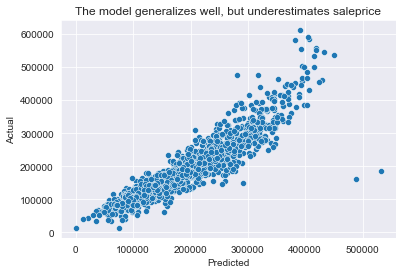

In [284]:
sns.scatterplot(x=train_pred, y=y_train)
plt.title('The model generalizes well, but underestimates saleprice')
plt.xlabel('Predicted')
plt.ylabel('Actual');

Comparing predicted vs actual prices, it seems that generally the model is still under-predicting house values. Also of note is two predictions where the mode way over-predicted the price. 

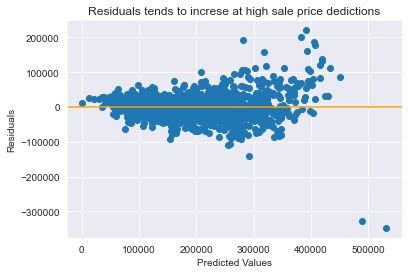

In [285]:
plt.scatter(train_pred, residuals)
#plt.title('The model does better predicting moderate to low priced houses')
plt.axhline(0, color='orange')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals tends to increse at high sale price dedictions')
plt.savefig('residuals');

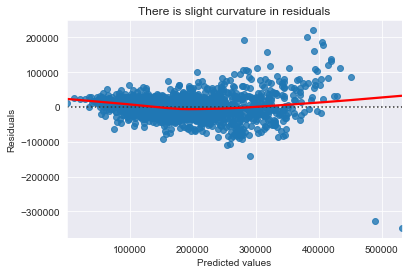

In [294]:
sns.residplot(x= train_pred, y= residuals, 
              lowess=True, line_kws = {'color':'red'})\
    .set(title='There is slight curvature in residuals', 
         xlabel='Predicted values',
         ylabel='Residuals');

Generally, the model continues to have difficulties predicting higher home values. 

In [287]:
list(zip(X_train_enc.columns, lr.coef_))

[('neighborhood_Blueste', 15929.971323126314),
 ('neighborhood_BrDale', 10077.530535548565),
 ('neighborhood_BrkSide', 18001.902579347956),
 ('neighborhood_ClearCr', 31864.637156888388),
 ('neighborhood_CollgCr', 22500.692473248957),
 ('neighborhood_Crawfor', 29181.183889755324),
 ('neighborhood_Edwards', -288.32289950652194),
 ('neighborhood_Gilbert', 22777.731508116987),
 ('neighborhood_Greens', 14071.46657504303),
 ('neighborhood_GrnHill', 113093.62897771984),
 ('neighborhood_IDOTRR', 15341.144640688792),
 ('neighborhood_Landmrk', 7050.070419298798),
 ('neighborhood_MeadowV', -21207.139469945083),
 ('neighborhood_Mitchel', 23390.779556429672),
 ('neighborhood_NAmes', 8309.52089640766),
 ('neighborhood_NPkVill', 10065.56747904725),
 ('neighborhood_NWAmes', 12846.76300442046),
 ('neighborhood_NoRidge', 61953.15826283829),
 ('neighborhood_NridgHt', 71423.2950554803),
 ('neighborhood_OldTown', 9886.30941330795),
 ('neighborhood_SWISU', 6629.598212019905),
 ('neighborhood_Sawyer', 12725.

### Analysis of the relevant coefficients

For the analysis of the coefficient, I will only focus on the coefficients of interest, meaning for variables that can be reasonably improved upon by sellers for the purpose of increasing house prices:

All the coefficient explanations are **ALL ELSE HELD CONSTANT**



|Feature|Type|Range|Coeficient|Exaplanation|
|---|---|---|---|---|
|Kitchen Quality|Ordinal|1-5|\$15580|For every unit increase in the quality of kitchen, house price increases \$15,580|
|Basement Finished Area|Ordinal|0-6|\$3,876|For every unit increase in the quality of the basement finish, house price increases \$15,580 dollars|
|Wood Deck (SF)|Continuous|--|$24.64|For every square foot of wooden deck, house price increases by \$24.64|
|Central Air|Nominal|Y/N|\$4,911|Houses with central air sale for \$4,911 more|
|Paved Driveway|Nominal|Y/N/P|\$5,191|Compared to homes with a gravel drive way, homes with paved drivewars sell for \$5,191 more|
|External Condition|Ordinal|1-5|\$18,400|For every unit increase in the exterial condition, house price increases \$18,400|
|Garage Quality|Ordinal|0-5|\$2,558|For every unit increase in the quality of garage, house price increases \$2,558|
|Electrical|Ordinal|1-5|\$316|For every unit increase in the quality of the electrical system, house price increases \$316|

**0 in the ordinal ranges mean the feature is not available

#### Analysis 

In the above analysis I explored house sale prices from Ames Iowa and created a simple linear regression model that can be used for home sellers in Ames to help guide which home renovation projects to undertake. 

The modeling process above was iterative, I started by creating a very simple linear regression model with numerical data that demonstrated high correlation with saleprices. I then move on to do a linear regression model that included categorical features. Adding these additional feaures did not add variability to the model, but still presented a low R-squared scores. 

I decided to then use lasso as a feature selection tool. I added all the available features to the lasso model, and realized that lasso was not converging at the default tolerance level. However, it narrowed down 81 features to only 31 features. I ran lasso again and further narrowed down to 25 features. I used the the features returned from lasso to add categorical variables into my model, knowing that lasso had helped decrease multicollinearity and noise. 

Running a simple regression model with 25 features that included most of the features returned from lasso and those of interest for potential home sellers did increase the R-square score, but the residuals for the model showed that the model was making a lot of errors when trying to predict home prices above 250,000 dollars. I also saw signs that there were multicollinearity issues, such as having negative coefficients in variables where that would not make sense, such as garage quality, to me this showed that the model was confused as to which one of the garage-related variables should be attributed for increase price. So in order to narrow down my features, reduce noise, and reduce multillinearity, I used lasson again. 

Running lasso again allowed me to narrow down my model to 21 features. Using the left-over coefficients from lasso into the linear regression model (to maintain easy interpretation of variables), improved my over all. While the R-squared score remain very similar, the mean average errors score was reduced and a plot of the residuals vs. predicted values showed that the model did improve, and that it improved its ability to predict higher house prices (at about 350,000 the model starts doing less well). This model also features the best MAE score, and I felt satisfied with using it for the purpose of advising clients. Looking at the slight curve in the residuals, we may have improved the model by adding some interactin terms, or log-transforming y, however, I prioritized maintaining a model that produced simple, and easy to explain coefficients. 


#### Conclusions and Recommendations

The final linear model is able to explain about 84% of the variability in sale prices. While the model can improve in it's R-squared score, its coefficients are very simple to explain and can provide home sellers with an estimated dollar amount on the return on their renovation investments. 

The model does a really good job in predicting home values below \$350,000 and can be confidently used when advisor home sellers with home values at around that price or lower. 

The coefficient produced by the model can help home sellers estimate the increase in home values when they add or improve certain home features. I recommend home sellers themselves use my table of coefficients so that they can compare the estimated increase in house value with the estimate that they get from their contractors and then make an educated decision on whether to add or improve the feature in questions. 

For instance, if a seller is considering renovating their kitchen, they may look at the estimated coefficient for kitchen quality and see that for every unit increase in kitchen quality, the home value increases by \$15,880. So if their remodling will bring their kitchen from avg to excellent, their sale price is estimated to increase by 31,160. However the home seller should consider the cost of this renovationm project and only undertake the effort if the cost is less than 31,160. 




#### Summit final model to Kraggle

In [288]:
preds = lr.predict(X_test_enc)

In [289]:
test['SalePrice'] = preds  

In [290]:
submission = test[['id', 'SalePrice']]

In [291]:
submission.shape

(878, 2)

In [292]:
pwd

'/Users/luisagonzalez/Library/CloudStorage/OneDrive-Personal/Documents/General_Assembly/Projects/project-2/Code'

In [293]:
submission.to_csv('../datasets/last_model.csv', index=False)